<a href="https://colab.research.google.com/github/reireu/for-copy/blob/main/RF_last_k_fold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

k-foldは交差学習をするもの。
学習用データと交差用データに分け、文サテンを少しずらしながら学習と評価を繰り返すことで妥当性とかを確認。

In [ ]:
CSV_DIR = "smartphone_shake_dataset/CSV"

import glob
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

def load_csv_files_to_features(file_list, label):
    features = []
    labels   = []

    for f in file_list:
        df = pd.read_csv(f)
        # 数値変換 / NaN補完
        for col in ["x","y","z","rotX","rotY","rotZ","gaze_x","gaze_y"]:
            df[col] = pd.to_numeric(df[col], errors='coerce')
        df = df.fillna(df.mean())

        # 特徴量(平均,標準偏差 × 8列 = 16次元)
        means = [df[col].mean() for col in ["x","y","z","rotX","rotY","rotZ","gaze_x","gaze_y"]]
        stds  = [df[col].std()  for col in ["x","y","z","rotX","rotY","rotZ","gaze_x","gaze_y"]]
        feature_vector = means + stds

        features.append(feature_vector)
        labels.append(label)

    return np.array(features), np.array(labels)

# 例: CSVファイルのパターン
class0_files = sorted(glob.glob(CSV_DIR + "/last_table*.csv"))
class1_files = sorted(glob.glob(CSV_DIR + "/last_chair*.csv"))

X0, y0 = load_csv_files_to_features(class0_files, label=0)
X1, y1 = load_csv_files_to_features(class1_files, label=1)

X = np.vstack([X0, X1])
y = np.hstack([y0, y1])

# KFoldで分割
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

fold_accs = []

# すべてのテストデータ&予測結果を蓄積し、最終的に全体での混同行列を出すため
all_y_test = []
all_y_pred = []

for fold_idx, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"\n----- FOLD {fold_idx+1} / {k} -----")

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test_cv = y[train_index], y[test_index]

    # ランダムフォレスト学習
    rf = RandomForestClassifier(
        n_estimators=5,
        max_depth=None,
        random_state=42
    )
    rf.fit(X_train, y_train)

    y_pred_cv = rf.predict(X_test)

    acc = accuracy_score(y_test_cv, y_pred_cv)
    print(f"Fold {fold_idx+1}: Test Accuracy = {acc:.4f}")
    fold_accs.append(acc)

    all_y_test.extend(y_test_cv)
    all_y_pred.extend(y_pred_cv)

# K-Foldの平均と標準偏差(パーセント表記)を最終的に表示
acc_mean = np.mean(fold_accs) * 100
acc_std  = np.std(fold_accs)  * 100

print(f"\nAcc:  {acc_mean:.2f}% ± {acc_std:.2f}%")


----- FOLD 1 / 5 -----
Fold 1: Test Accuracy = 0.7273

----- FOLD 2 / 5 -----
Fold 2: Test Accuracy = 0.6364

----- FOLD 3 / 5 -----
Fold 3: Test Accuracy = 0.8182

----- FOLD 4 / 5 -----
Fold 4: Test Accuracy = 0.6364

----- FOLD 5 / 5 -----
Fold 5: Test Accuracy = 0.7273

Acc:  70.91% ± 6.80%


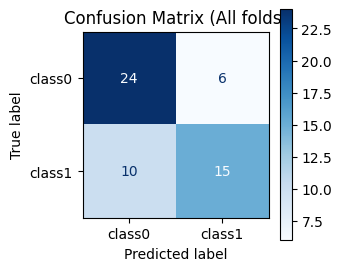

              precision    recall  f1-score   support

      class0       0.71      0.80      0.75        30
      class1       0.71      0.60      0.65        25

    accuracy                           0.71        55
   macro avg       0.71      0.70      0.70        55
weighted avg       0.71      0.71      0.71        55



In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# K-Foldの全テストデータに対する実際のラベル (all_y_test)
# および 予測ラベル (all_y_pred) を元に混同行列とレポートを出す

cm = confusion_matrix(all_y_test, all_y_pred)  # 行: 真のクラス, 列: 予測クラス
disp = ConfusionMatrixDisplay(cm, display_labels=["class0", "class1"])
disp.plot(cmap=plt.cm.Blues)

plt.rcParams["figure.figsize"] = (3,3)
plt.title("Confusion Matrix (All folds)")
plt.show()

# Precision / Recall / F1
report = classification_report(all_y_test, all_y_pred, target_names=["class0", "class1"])
print(report)

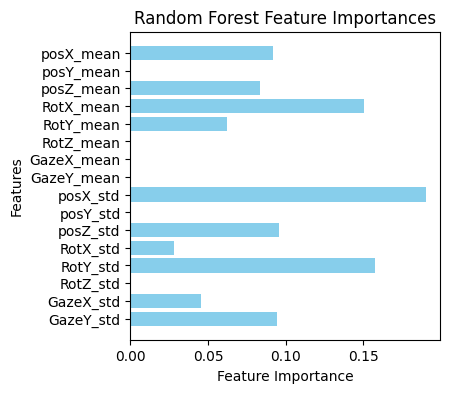

In [ ]:
# RandomForestClassifierモデルを rf として
importances = rf.feature_importances_
feature_names = [
    "posX_mean","posY_mean","posZ_mean",
    "RotX_mean", "RotY_mean", "RotZ_mean",
    "GazeX_mean", "GazeY_mean",
    "posX_std", "posY_std", "posZ_std",
    "RotX_std", "RotY_std", "RotZ_std",
    "GazeX_std", "GazeY_std"
]

# バーで可視化
plt.figure(figsize=(4,4))
plt.barh(feature_names, importances, color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Random Forest Feature Importances")
plt.gca().invert_yaxis()  # 上をfeature_namesの先頭に
plt.show()

In [ ]:
import numpy as np

# たとえば、X0, y0 は class0 に相当する特徴量・ラベル
#           X1, y1 は class1 に相当する特徴量・ラベル
# という前提で、X0, X1 を既に作成済みとする

# X0, X1 は shape = (サンプル数, 特徴次元) の Numpy配列 (16次元など)

# class0 の各特徴量の標準偏差
std_class0 = np.std(X0, axis=0)  # 特徴次元ごとに計算
# class1 の各特徴量の標準偏差
std_class1 = np.std(X1, axis=0)

print("===== Standard Deviation of Features =====")

# 各次元の名前(例) - 平均8つ＋標準偏差8つ と仮定
feature_names = [
    "posX_mean","posY_mean","posZ_mean",
    "RotX_mean", "RotY_mean", "RotZ_mean",
    "GazeX_mean", "GazeY_mean",
    "posX_std", "posY_std", "posZ_std",
    "RotX_std", "RotY_std", "RotZ_std",
    "GazeX_std", "GazeY_std"
]

for i, f_name in enumerate(feature_names):
    print(f"{f_name}: class0 std = {std_class0[i]:.4f}, class1 std = {std_class1[i]:.4f}")

===== Standard Deviation of Features =====
posX_mean: class0 std = 1.7329, class1 std = 1.5217
posY_mean: class0 std = 0.0000, class1 std = 0.0000
posZ_mean: class0 std = 0.2929, class1 std = 0.3598
RotX_mean: class0 std = 0.1300, class1 std = 0.1196
RotY_mean: class0 std = 0.1548, class1 std = 0.2061
RotZ_mean: class0 std = 0.0000, class1 std = 0.0000
GazeX_mean: class0 std = 87.0891, class1 std = 105.6063
GazeY_mean: class0 std = 95.2772, class1 std = 97.9390
posX_std: class0 std = 0.3172, class1 std = 0.6229
posY_std: class0 std = 0.0000, class1 std = 0.0000
posZ_std: class0 std = 0.2315, class1 std = 0.4143
RotX_std: class0 std = 0.0312, class1 std = 0.0369
RotY_std: class0 std = 0.0956, class1 std = 0.1151
RotZ_std: class0 std = 0.0000, class1 std = 0.0000
GazeX_std: class0 std = 328.6521, class1 std = 81.2599
GazeY_std: class0 std = 245.8977, class1 std = 35.4216
